# Demo - Running a ML model on the GPU 

### Running everything in their own environments gives complete reproducibilty

In [51]:
]activate .

Activating environment at `~/mlds/Project.toml`


In [52]:
]st

Status `~/mlds/Project.toml`
  [336ed68f] CSV v0.5.22
  [31c24e10] Distributions v0.21.12
  [587475ba] Flux v0.10.1
  [86fae568] ImageView v0.10.4
  [916415d5] Images v0.20.2
  [23992714] MAT v0.7.0
  [91a5bcdd] Plots v0.28.4
  [2913bbd2] StatsBase v0.32.0
  [10745b16] Statistics 


## Defining some utility functions

In [53]:
include.(("utils.jl", "dataloader.jl"))

(loss, load_batch)

Checkout the model architecture, and its implementation

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [54]:
using Flux
using Flux: @functor

## Really easy and intuitive custom layers

In [55]:
# Designing a custom layer

struct UNetUpBlock
  upsample
end

@functor UNetUpBlock

# The layer construction in this case wraps a Chain, but it doesn't need to
function UNetUpBlock(in_chs::Int, out_chs::Int; kernel = (3, 3), p = 0.5f0)
    upsample = Chain(x->leakyrelu.(x,0.2f0),
                  ConvTranspose((2, 2), in_chs=>out_chs,
                    stride=(2, 2);init=_random_normal),
                  BatchNormWrap(out_chs)...,
                  Dropout(p))

    UNetUpBlock(upsample)
end

# Forward pass of our layer
function (u::UNetUpBlock)(x, bridge)
  x = u.upsample(x)
  return cat(x, bridge, dims = 3)
end

## Sampling some of the images from the dataset

The images come from the kaggle dataset about identifying pneumonia in patients. <br>
Link: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge

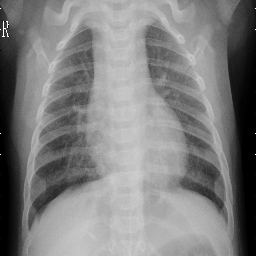

In [56]:
load_img("person1000_virus_1681.jpeg")

,,

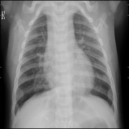
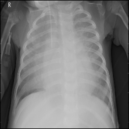
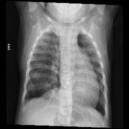

In [57]:
load_img.(["person1000_virus_1681.jpeg","person1004_bacteria_2935.jpeg","person1006_bacteria_2937.jpeg"])

### Defining some more layers...

In [58]:
function BatchNormWrap(out_ch)
  Chain(x->expand_dims(x,2),
    BatchNorm(out_ch),
    x->squeeze(x))
end

UNetConvBlock(in_chs, out_chs, kernel = (3, 3)) =
  Chain(Conv(kernel, in_chs=>out_chs,pad = (1, 1);init=_random_normal),
    BatchNormWrap(out_chs)...,
    x->leakyrelu.(x,0.2f0))

ConvDown(in_chs,out_chs,kernel = (4,4)) =
  Chain(Conv(kernel,in_chs=>out_chs,pad=(1,1),stride=(2,2);init=_random_normal),
    BatchNormWrap(out_chs)...,
    x->leakyrelu.(x,0.2f0))

ConvDown (generic function with 2 methods)

And finally, the actual model itself can be thought of its own model!

In [59]:
struct UNet
  conv_down_blocks
  conv_blocks
  up_blocks
end

@functor UNet

function UNet()
  conv_down_blocks = Chain(ConvDown(64,64),
		ConvDown(128,128),
		ConvDown(256,256),
		ConvDown(512,512))

  conv_blocks = Chain(UNetConvBlock(1, 3),
		UNetConvBlock(3, 64),
		UNetConvBlock(64, 128),
		UNetConvBlock(128, 256),
		UNetConvBlock(256, 512),
		UNetConvBlock(512, 1024),
		UNetConvBlock(1024, 1024))

  up_blocks = Chain(UNetUpBlock(1024, 512),
		UNetUpBlock(1024, 256),
		UNetUpBlock(512, 128),
		UNetUpBlock(256, 64,p = 0.0f0),
		Chain(x->leakyrelu.(x,0.2f0),
		Conv((1, 1), 128=>1;init=_random_normal)))
  
  UNet(conv_down_blocks, conv_blocks, up_blocks)
end

function (u::UNet)(x)
  outputs = Vector(undef, 5)
  outputs[1] = u.conv_blocks[1:2](x)

  for i in 2:5
    pool_x = u.conv_down_blocks[i - 1](outputs[i - 1])
    outputs[i] = u.conv_blocks[i+1](pool_x)
  end

  up_x = u.conv_blocks[7](outputs[end])

  for i in 1:4
    up_x = u.up_blocks[i](up_x, outputs[end - i])
  end

  tanh.(u.up_blocks[end](up_x))
end

In [60]:
u = UNet();

In [61]:
x, y = load_batch(rsize = (256, 256));

# Move the model up to the GPU !

Moving the actual compute over to the GPU is very easy, even for custom layers and can be done with a single call to the `gpu` function, for models, data etc.

In [62]:
gu = gpu(u);

And the data, too...

In [63]:
gx, gy = gpu(x), gpu(y);

# Benchmark the difference

In [64]:
using BenchmarkTools

### Benchmarking on the CPU

In [65]:
@btime u(x);

  59.803 s (3383 allocations: 8.91 GiB)


### Benchmarking on the GPU

In [ ]:
@btime Flux.CuArrays.@sync gu($gx);

## That's a performance boost of about **300x**